In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
from tqdm import tqdm

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh

plt.style.use('science')

In [2]:
INIT_CONDITIONS = np.array([0, 0.1])
DEFAULT_ENDPTS = np.array([1e-6, 60])

def wave_function(v_r, energy, r_endpts=DEFAULT_ENDPTS, tol=1e-12):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, INIT_CONDITIONS, rtol=tol, atol=tol,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def wave_function_tail(energy, v_r, r0):
    sol = wave_function(v_r, energy)
    return sol(r0)[0]


def normalization_constant(energy, v_r, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    return 1/np.sqrt(np.dot(wr, u**2))
    

def normalized_wave_function(energy, v_r, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return normalization_constant(energy, v_r, r_max=r_max, tol=tol) * u

In [3]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
mm_spec = np.loadtxt('spectra_Mott_Massey_hp.txt')

In [4]:
mm_gammas = np.sqrt(2*MU*-mm_spec)
rs_max = -1/mm_gammas * np.log(1e-6)

In [5]:
rs_max

array([ 2.48955835,  3.01253149,  3.82687461,  5.23212399,  8.1006797 ,
       16.02279597, 57.77452614])

In [6]:
guesses = mm_spec.copy()
energies = []

for i in tqdm(range(rgf.shape[0])):
    Ri, gi = rgf[i]
    pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)
    
    e2s = np.array([
        optimize.fsolve(lambda e: wave_function_tail(e, pot, r_max), en) for (en, r_max) in zip(guesses, rs_max)
    ])
    guesses = e2s.copy()
    energies.append(e2s)

100%|███████████████████████████████████████████| 90/90 [11:28<00:00,  7.65s/it]


In [7]:
energies = np.array(energies)
n = energies.shape[0]

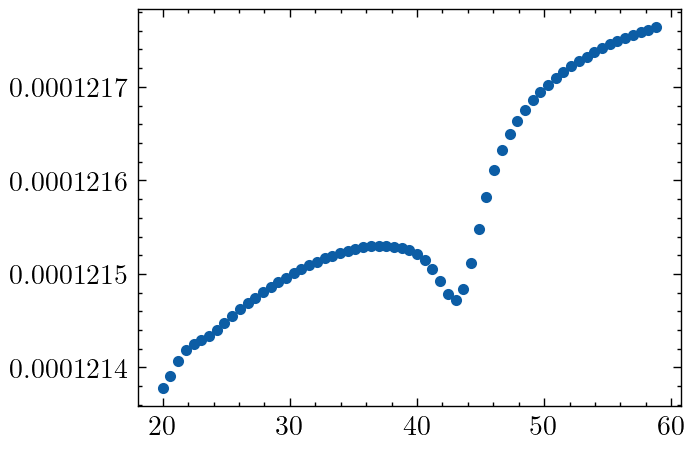

In [21]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(BETA4/rgf[:65, 0], np.abs(energies[:65, -1]), marker='.');

In [22]:
from scipy.interpolate import interp1d

In [24]:
energies.shape

(90, 7, 1)

In [28]:
more_energies = []

for i in tqdm(range(65, rgf.shape[0])):
    Ri, gi = rgf[i]
    pot = lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri)
    
    funcs = [interp1d(rgf[i-5:i, 0], energies[i-5:i, j, 0], kind='cubic', fill_value='extrapolate') for j in range(7)]
    guesses = np.array([f(Ri) for f in funcs])
    
    e2s = np.array([
        optimize.fsolve(lambda e: wave_function_tail(e, pot, r_max), en) for (en, r_max) in zip(guesses, rs_max)
    ])
    more_energies.append(e2s)

100%|███████████████████████████████████████████| 25/25 [05:33<00:00, 13.33s/it]


In [29]:
more_energies = np.array(more_energies)

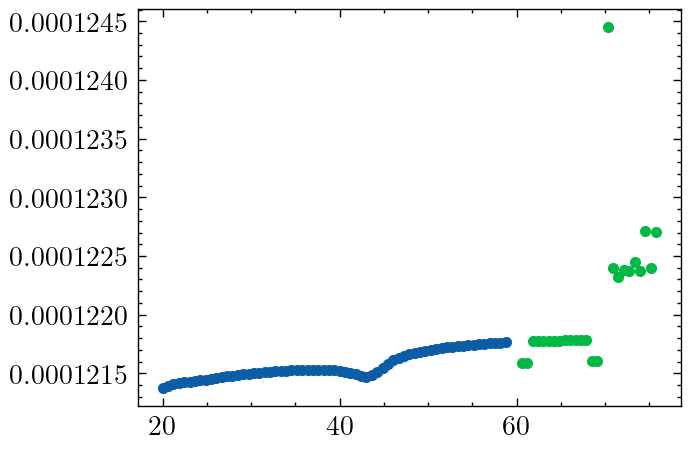

In [31]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(BETA4/rgf[:65, 0], np.abs(energies[:65, -1]), marker='.')
ax.scatter(BETA4/rgf[65:, 0], np.abs(more_energies[:, -1]), marker='.');